<a href="https://colab.research.google.com/github/megnidio/DPR/blob/main/machine_learning_for_particle_physics_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Megnidio script that explain how to effectively deploy machine learning techniques for particle physics data.

Packages and libraries

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from scipy.stats import shapiro
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import scale
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Importing Data and cleaning#

In [ ]:
#Predicting the Electron Invariant Mass
#We load and explore data
CERN = pd.read_csv("dielectron.csv.zip")
CERN.head()


,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718



Preprocessing
(The first two columns were only intended to identify the data that was included, so they were eliminated.)

In [ ]:
# We will focus on numerical columns, we do not need event IDs
CERN = CERN.drop(["Run","Event"],axis=1)

In [ ]:
#Removing extra keywords:
CERN.rename(columns={'px1 ':'px1'}, inplace=True) # "px 1" is not comfortable

In [ ]:
 # copy to protect main data
data = CERN.copy()
data.head()

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


In [ ]:
#prints information about the DataFrame (number of columns, column labels, column data types, memory usage, range index, and the number of cells in each column (non-null values))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   E1      100000 non-null  float64
 1   px1     100000 non-null  float64
 2   py1     100000 non-null  float64
 3   pz1     100000 non-null  float64
 4   pt1     100000 non-null  float64
 5   eta1    100000 non-null  float64
 6   phi1    100000 non-null  float64
 7   Q1      100000 non-null  int64  
 8   E2      100000 non-null  float64
 9   px2     100000 non-null  float64
 10  py2     100000 non-null  float64
 11  pz2     100000 non-null  float64
 12  pt2     100000 non-null  float64
 13  eta2    100000 non-null  float64
 14  phi2    100000 non-null  float64
 15  Q2      100000 non-null  int64  
 16  M       99915 non-null   float64
dtypes: float64(15), int64(2)
memory usage: 13.0 MB


In [ ]:
#checking for missing values
data.isnull().sum()

E1       0
px1      0
py1      0
pz1      0
pt1      0
eta1     0
phi1     0
Q1       0
E2       0
px2      0
py2      0
pz2      0
pt2      0
eta2     0
phi2     0
Q2       0
M       85
dtype: int64

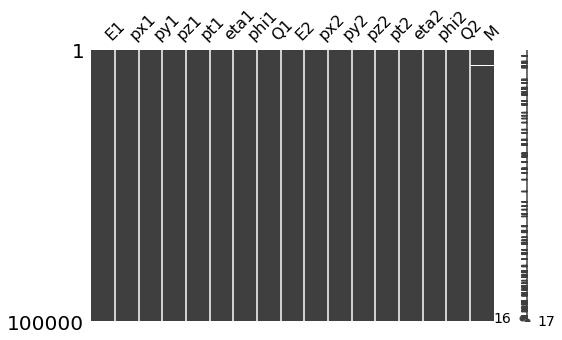

In [ ]:
#Let's take a look at the correlation between missing data by visualizing it
msno.matrix(data,figsize=(8,5))
plt.show()

In [ ]:
#it seems missing values are acceptable, we can drop rows with missing values
#data=data.dropna()

In [ ]:
#it seems missing values are acceptable, but we can impute them using median
# Let's add median corresponding to that data instead of the NaN data
data["M"].fillna(data["M"].median(),inplace=True)
data.isnull().sum() # checking again

E1      0
px1     0
py1     0
pz1     0
pt1     0
eta1    0
phi1    0
Q1      0
E2      0
px2     0
py2     0
pz2     0
pt2     0
eta2    0
phi2    0
Q2      0
M       0
dtype: int64

#Exploratory data analysis#

In [ ]:
# print a statistical summary of the data
data.describe()

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,36.436466,0.135897,0.182291,-1.508037,14.412167,-0.064095,0.021614,-0.00548,44.002901,-0.003984,0.124654,-1.590559,13.802036,-0.072830,0.021385,-0.004220,30.012095
std,41.216203,13.404976,13.470281,51.603652,12.388740,1.462137,1.799562,0.99999,46.751132,13.127404,13.168867,61.430040,12.460549,1.738033,1.817031,0.999996,25.246394
min,0.377928,-250.587000,-126.079000,-840.987000,0.219629,-4.165380,-3.141580,-1.00000,0.472500,-233.730000,-145.651000,-655.396000,0.026651,-7.064790,-3.141580,-1.000000,2.000080
25%,8.458595,-5.233675,-5.276248,-15.859825,3.771172,-1.283883,-1.527030,-1.00000,11.055725,-4.794770,-4.605965,-22.036950,3.738103,-1.892287,-1.556925,-1.000000,12.453575
50%,21.717000,0.141339,0.099092,-0.312987,12.967800,-0.061178,0.034324,-1.00000,25.264600,-0.035638,0.083665,-0.690244,11.690950,-0.135911,0.026986,-1.000000,21.283100
75%,50.003350,5.714560,5.648087,13.212650,20.018925,1.144408,1.562355,1.00000,66.925525,4.819540,5.061860,19.005825,19.596400,1.768253,1.596737,1.000000,38.992250
max,850.602000,134.539000,147.467000,760.096000,265.578000,2.622970,3.141420,1.00000,948.375000,227.330000,166.283000,935.558000,281.654000,3.060550,3.141290,1.000000,109.999000


Co-relation between variables

In [ ]:
corrPearson = data.corr(method="pearson")
corrSpearman = data.corr(method="spearman")

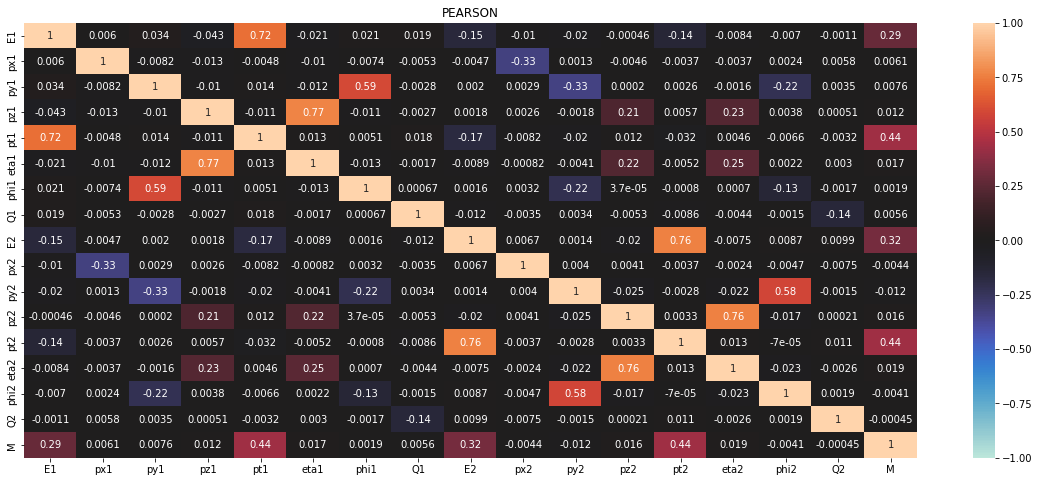

In [ ]:
figure = plt.figure(figsize=(20,8))
sns.heatmap(corrPearson,annot=True,vmin=-1,center=0,vmax=1)
plt.title("PEARSON")
plt.show()

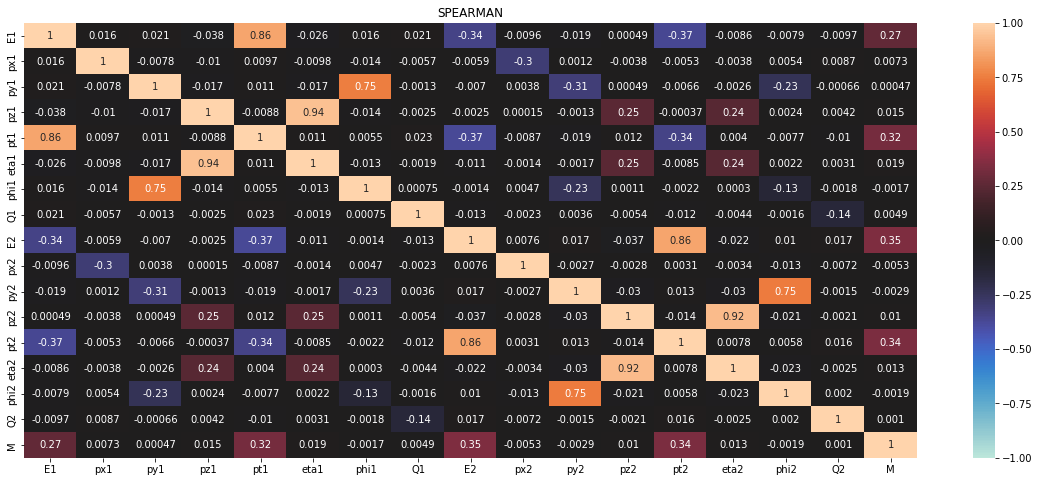

In [ ]:
figure = plt.figure(figsize=(20,8))
sns.heatmap(corrSpearman,annot=True,vmin=-1,center=0,vmax=1)
plt.title("SPEARMAN")
plt.show()

In [ ]:
covv = data.cov()

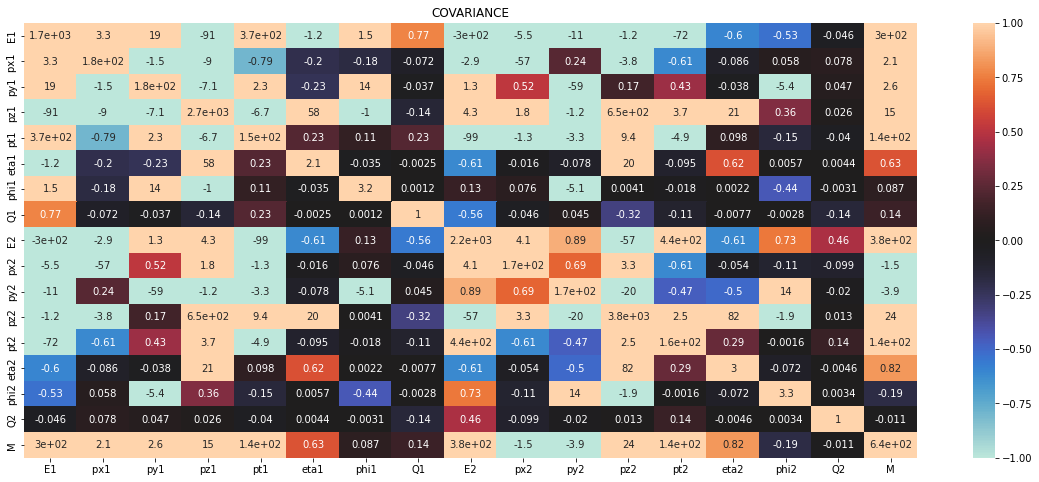

In [ ]:
figure = plt.figure(figsize=(20,8))
sns.heatmap(covv,annot=True,vmin=-1,center=0,vmax=1)
plt.title("COVARIANCE")
plt.show()

#Data visualization#

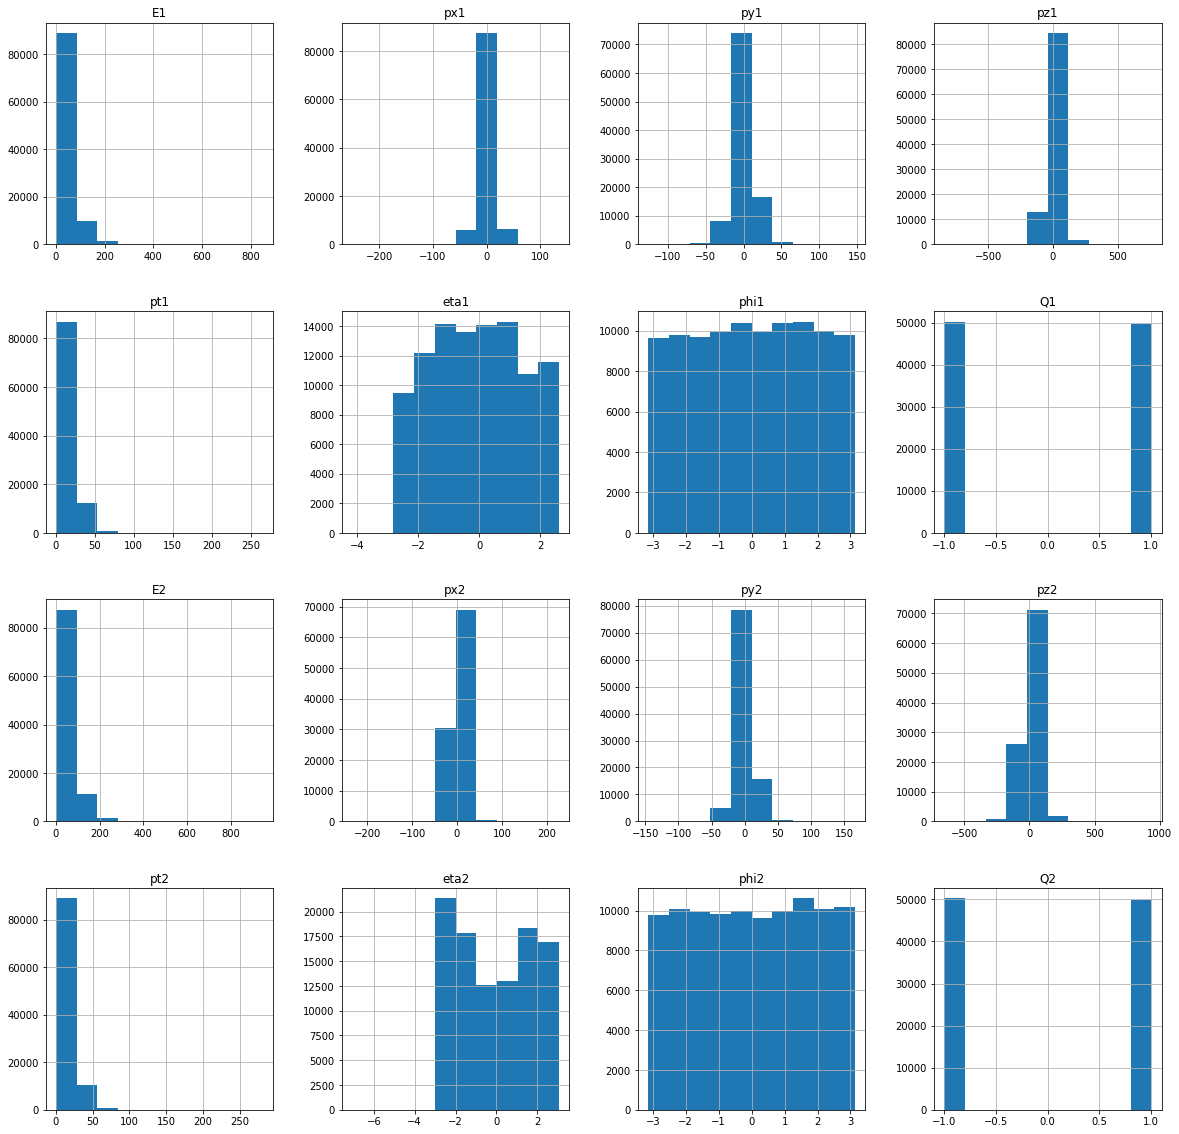

In [ ]:
#Basic histogram
data.iloc[:,0:16].hist(figsize=(20,20))
plt.show()

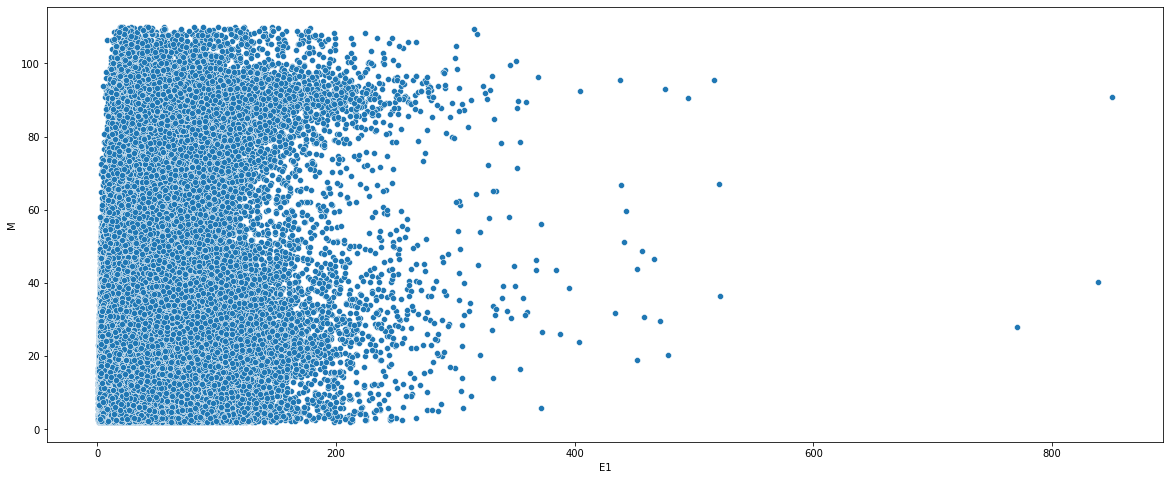

In [ ]:
#scatter plot
#All the scatter plots verify the strong correlations between different coefficients.
figure = plt.figure(figsize=(20,8))
sns.scatterplot(x="E1",y="M",data=data)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


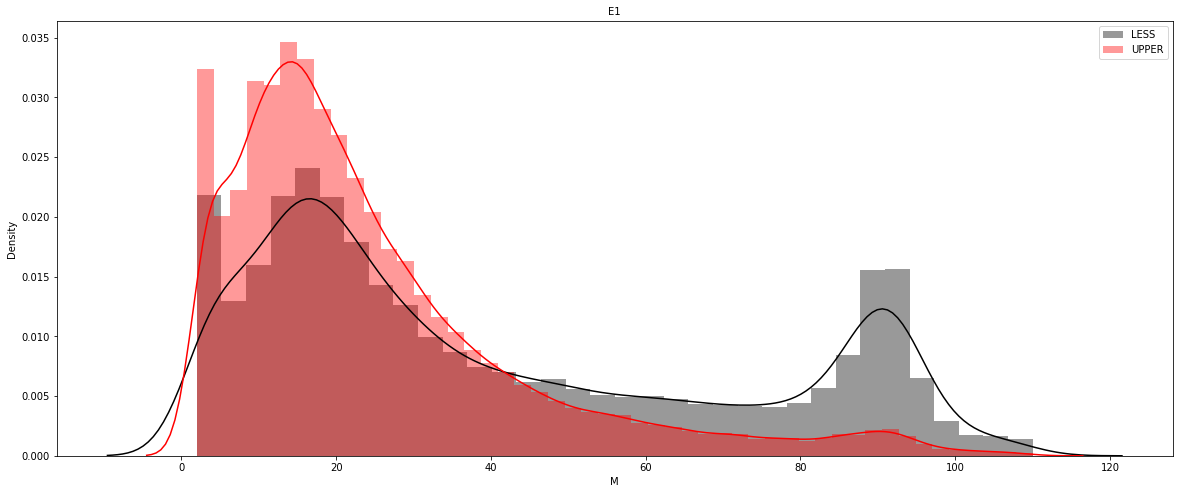

In [ ]:
#Distplot
figure = plt.figure(figsize=(20,8))
sns.distplot(data[data['E1'] > data['E1'].mean()]["M"], color='black',label='LESS')
sns.distplot(data[data['E1'] < data['E1'].mean()]["M"], color='red',label='UPPER')
plt.title('E1', fontsize=10)
plt.legend()

<Figure size 1440x576 with 0 Axes>

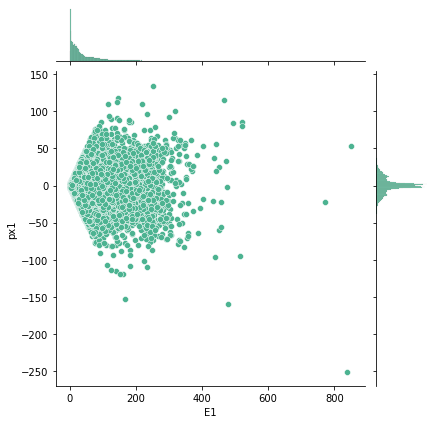

In [ ]:
#Jointplot
figure = plt.figure(figsize=(20,8))
sns.jointplot(x="E1",y="px1", color="#4CB391",data=data)
plt.show()

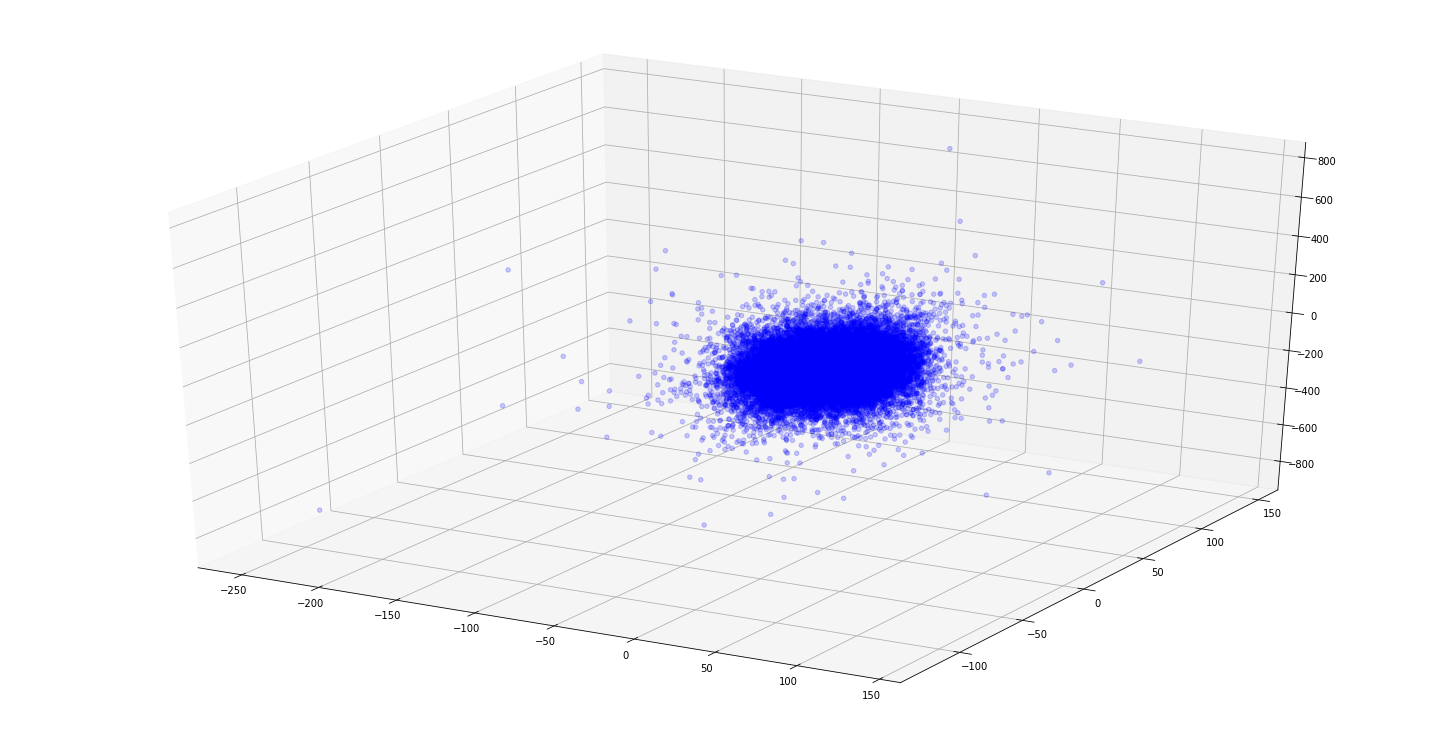

In [ ]:
#3D plot
fig = plt.figure(figsize=(20,10))
ax = Axes3D(fig)
ax.scatter(data["px1"], data["py1"], data["pz1"], c="blue", s=20, alpha=0.2)
plt.show()

#Machine Learning#
 (In this part, we will compare
machine learning capabilities for estimating the invariant mass of electrons.)

In [ ]:
#Choosing features and selecting the prediction target
x = data.drop("M",axis=1)
y = data["M"]
# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
xTrain,xTest,yTrain,yTest = train_test_split(x,y,test_size=0.2,random_state=42)

Evaluate several models

In [ ]:
# Define and fit your models
lm = LinearRegression().fit(xTrain,yTrain)
pls = PLSRegression().fit(xTrain,yTrain)
ridge = Ridge().fit(xTrain,yTrain)
lasso = Lasso().fit(xTrain,yTrain)
elasticnet = ElasticNet().fit(xTrain,yTrain)
knnr = KNeighborsRegressor().fit(xTrain,yTrain)
cartr = DecisionTreeRegressor(random_state=42).fit(xTrain,yTrain)
baggr = BaggingRegressor(random_state=42,bootstrap_features=True,verbose=False).fit(xTrain,yTrain)
rfr = RandomForestRegressor(random_state=42,verbose=False).fit(xTrain,yTrain)
gbmr = GradientBoostingRegressor(verbose=False).fit(xTrain,yTrain)
xgbr = XGBRegressor().fit(xTrain,yTrain)
lgbmr = LGBMRegressor().fit(xTrain,yTrain)
catbr = CatBoostRegressor(verbose=False).fit(xTrain,yTrain)

[08:00:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
models = [lm,pls,ridge,lasso,elasticnet,knnr,
         cartr,baggr,rfr,gbmr,xgbr,lgbmr,catbr]

In [ ]:
#Use the models to make predictions
# Function for comparing different models
#R-squared is a regression model goodness-of-fit metric.
for model in models:
    name = model.__class__.__name__
    R2CV = cross_val_score(model,xTest,yTest,cv=10,scoring="r2").mean()
    error = -cross_val_score(model,xTest,yTest,cv=10,scoring="neg_mean_squared_error").mean()
    print(name + ": ")
    print("-" * 10)
    print(R2CV)
    print(np.sqrt(error))
    print("-" * 30)

LinearRegression: 
----------
0.40527041890945326
19.476432011333667
------------------------------
PLSRegression: 
----------
0.4003063950414911
19.5574338935971
------------------------------
Ridge: 
----------
0.4052704354267057
19.476431741632922
------------------------------
Lasso: 
----------
0.40552788633427134
19.472279931902865
------------------------------
ElasticNet: 
----------
0.4054388007788111
19.473731275370078
------------------------------
KNeighborsRegressor: 
----------
0.886945474307922
8.491734225865622
------------------------------
DecisionTreeRegressor: 
----------
0.6071672063829866
15.825485657509223
------------------------------
BaggingRegressor: 
----------
0.8622002567153235
9.374695061682962
------------------------------
RandomForestRegressor: 
----------
0.8973652785217026
8.090083604003354
------------------------------
GradientBoostingRegressor: 
----------
0.7629554782239747
12.307437570055738
------------------------------
[08:31:17] WARNING: /wo

The best model is CatBoostRegressor with R-square = 0.9895776897205797